<a href="https://colab.research.google.com/github/kavyajeetbora/EAST/blob/master/EAST_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Imports

[**Tasks - Incidental Scene Text**](https://rrc.cvc.uab.es/?ch=4&com=tasks)

In [0]:
import os
import time
from PIL import Image
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import shutil
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%%time
!rm -r /content/cloned-repo
%cd ..
!git clone -l -s git://github.com/kavyajeetbora/EAST.git /content/cloned-repo
%cd /content/cloned-repo
!ls

rm: cannot remove '/content/cloned-repo': No such file or directory
/
Cloning into '/content/cloned-repo'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (103/103), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 185 (delta 58), reused 0 (delta 0), pack-reused 82
Receiving objects: 100% (185/185), 7.10 MiB | 9.52 MiB/s, done.
Resolving deltas: 100% (103/103), done.
/content/cloned-repo
dataset.py		    EAST_resnet.py		    model.py
detect.py		    EAST_training.ipynb		    model_resnet.py
dsiplay_ground_truth.ipynb  EAST_training_vgg16_bn_2.ipynb  train.py
EAST_detection.ipynb	    loss.py
CPU times: user 169 ms, sys: 22.5 ms, total: 191 ms
Wall time: 13.5 s


In [0]:
from dataset import *

In [5]:
%%time

# AI4Bharat dataset
image_folder = '/content/drive/My Drive/Colab Notebooks (1)/padh.ai.notebooks/15. Object Detection/AI4Bharat Dataset/Test Set/Images'
label_folder = '/content/drive/My Drive/Colab Notebooks (1)/padh.ai.notebooks/15. Object Detection/AI4Bharat Dataset/Test Set/Annotations'

training_dataset = custom_dataset(image_folder, label_folder)
print(len(training_dataset))

428
CPU times: user 3.33 ms, sys: 1.48 ms, total: 4.81 ms
Wall time: 7.01 s


## Loss for one batch

In [6]:
%%time
train_loader = DataLoader(training_dataset, shuffle = True, batch_size=12, drop_last=True)
imgs, gt_score, gt_geo, ignored_maps = next(iter(train_loader))
print(imgs.size(), gt_score.size(), gt_geo.size(), ignored_maps.size())
print(torch.sum(gt_score))

torch.Size([12, 3, 512, 512]) torch.Size([12, 1, 128, 128]) torch.Size([12, 5, 128, 128]) torch.Size([12, 1, 128, 128])
tensor(19162.)
CPU times: user 6.24 s, sys: 6.41 s, total: 12.7 s
Wall time: 14.3 s


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
%%time
from model import EAST
model = EAST()
pretrained_path = '/content/drive/My Drive/Colab Notebooks (1)/padh.ai.notebooks/15. Object Detection/EAST scene text detector/model_epoch_50.pth'
state_dict = torch.load(pretrained_path)
model.load_state_dict(state_dict)
model = model.to(device)
imgs, gt_score, gt_geo, ignored_maps = imgs.to(device), gt_score.to(device), gt_geo.to(device), ignored_maps.to(device)
pred_score, pred_geo = model(imgs)

print(pred_score.size(), pred_geo.size())

Downloading: "http://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:06<00:00, 91.5MB/s]


torch.Size([12, 1, 128, 128]) torch.Size([12, 5, 128, 128])
CPU times: user 6.6 s, sys: 2.55 s, total: 9.14 s
Wall time: 16.5 s


In [9]:
from loss import Loss

loss_fn = Loss()
loss_fn(gt_score, pred_score, gt_geo, pred_geo, ignored_maps)

classify loss is 0.08073783, angle loss is 0.00073752, iou loss is 0.20274970


tensor(0.2909, device='cuda:0', grad_fn=<AddBackward0>)

## Training Full Batch 

fine tuning pretrained model [east_vgg16.pth](https://drive.google.com/file/d/1AFABkJgr5VtxWnmBU3XcfLJvpZkC2TAg/view)

In [0]:
torch.cuda.empty_cache()

In [0]:
model = EAST()
pretrained_path = '/content/drive/My Drive/Colab Notebooks (1)/padh.ai.notebooks/15. Object Detection/EAST scene text detector/model_epoch_50.pth'
state_dict = torch.load(pretrained_path)
model.load_state_dict(state_dict)
model = model.to(device)

In [0]:
def train(model, train_img_path, train_gt_path, batch_size, lr, epoch_iter, num_workers=4, interval=1):
    file_num = len(os.listdir(train_img_path))
    print(file_num)
    trainset = custom_dataset(train_img_path, train_gt_path)
    train_loader = data.DataLoader(trainset, batch_size=batch_size, \
                                   shuffle=True, num_workers=num_workers, drop_last=True)
	
    criterion = Loss()
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=epoch_iter//25, gamma=0.5)
    loss_curve = []
    
    for epoch in range(epoch_iter):
      model.train()
      scheduler.step()
      epoch_loss = 0
      epoch_time = time.time()
      for i, (img, gt_score, gt_geo, ignored_map) in enumerate(train_loader):
        start_time = time.time()
        img, gt_score, gt_geo, ignored_map = img.to(device), gt_score.to(device), gt_geo.to(device), ignored_map.to(device)
        pred_score, pred_geo = model(img)
        loss = criterion(gt_score, pred_score, gt_geo, pred_geo, ignored_map)

        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print('Epoch is [{}/{}], mini-batch is [{}/{}], time consumption is {:.8f}, batch_loss is {:.8f}'.format(\
                  epoch+1, epoch_iter, i+1, int(file_num/batch_size), time.time()-start_time, loss.item()))
        
      print('epoch_loss is {:.8f}, epoch_time is {:.8f}'.format(epoch_loss/int(file_num/batch_size), time.time()-epoch_time))
      print(time.asctime(time.localtime(time.time())))
      print('='*50)
      
      
      if (epoch + 1) % interval == 0:
        state_dict = model.state_dict()
        torch.save(state_dict, 'model_epoch_{}.pth'.format(epoch+1))
       
      ## plotting the loss curve
      loss_curve.append(epoch_loss/int(file_num/batch_size))

    return loss_curve

In [20]:
%%time
loss_curve = train(model, image_folder, label_folder, batch_size=8, lr=1e-4, epoch_iter=200, interval = 10)

428


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


classify loss is 0.07482994, angle loss is 0.00126899, iou loss is 0.18971170
Epoch is [1/200], mini-batch is [1/53], time consumption is 0.54549575, batch_loss is 0.27723151
classify loss is 0.06698036, angle loss is 0.00084607, iou loss is 0.18776494
Epoch is [1/200], mini-batch is [2/53], time consumption is 0.27818537, batch_loss is 0.26320603
classify loss is 0.08955950, angle loss is 0.01212040, iou loss is 0.23479670
Epoch is [1/200], mini-batch is [3/53], time consumption is 0.21573591, batch_loss is 0.44556022
classify loss is 0.07634521, angle loss is 0.00112051, iou loss is 0.19009605
Epoch is [1/200], mini-batch is [4/53], time consumption is 0.19920301, batch_loss is 0.27764639
classify loss is 0.09627926, angle loss is 0.00227603, iou loss is 0.20765400
Epoch is [1/200], mini-batch is [5/53], time consumption is 0.21228671, batch_loss is 0.32669359
classify loss is 0.08207905, angle loss is 0.00305682, iou loss is 0.16894707
Epoch is [1/200], mini-batch is [6/53], time co

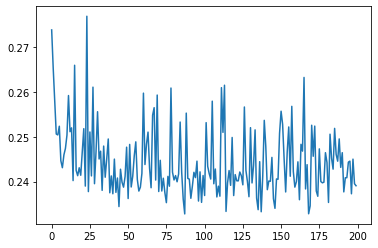

In [21]:
plt.plot(loss_curve)

1. [**Adam and AdamW algorithms**](https://www.fast.ai/2018/07/02/adam-weight-decay/)

2. [**The optimal learning rate during fine-tuning of an artificial neural network**](https://www.mikulskibartosz.name/the-optimal-learning-rate-during-fine-tuning-of-an-artificial-neural-network/)

In [0]:
state_dict = torch.load('/content/cloned-repo/model_epoch_50.pth')